In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [17]:
# Uploading all datasets
wid_raw = pd.read_csv('/content/drive/MyDrive/techlabs/wid/WDIData.csv')
lifestock = pd.read_csv('/content/drive/MyDrive/techlabs/lifestock.csv', index_col='Date')
soyworld = pd.read_csv('/content/drive/MyDrive/techlabs/soy-production-yield-area.csv')
palmoil = pd.read_csv('/content/drive/MyDrive/techlabs/land-use-palm-oil.csv')
land_use = pd.read_csv('/content/drive/MyDrive/techlabs/land_use.csv')

In [18]:
# Merge datasets in one dataset
soy = soyworld[(soyworld['Entity'] == 'Brazil')]
soy.drop(columns=['Entity', 'Code', 'Crops - Soybeans - 236 - Production - 5510 - tonnes', 'Crops - Soybeans - 236 - Yield - 5419 - hg/ha'], inplace=True)
soy.set_index('Year', inplace=True)
soy = soy.loc[1990:2018,:]

palm = palmoil[(palmoil['Entity'] == 'Brazil')]
palm.drop(columns=['Entity', 'Code'], inplace=True)
palm.set_index('Year', inplace=True)
palm = palm.loc[1990:2018,:]

brazil = wid_raw[(wid_raw['Country Name'] =='Brazil')]
brazil_new = brazil.drop(columns = ['Country Name', 'Country Code', 'Indicator Code'])
bra = brazil_new.T
header=bra.iloc[0]
bra=bra[1:]
bra.columns=header
useful_info = bra[["Agricultural land (sq. km)", "Crop production index (2014-2016 = 100)", "Land under cereal production (hectares)", "Land area (sq. km)", "Forest area (sq. km)", "Arable land (hectares)"]]
#"Forest area (% of land area)", "Arable land (hectares per person)", "Agricultural land (% of land area)", "Permanent cropland (% of land area)", "Arable land (% of land area)", "Cereal yield (kg per hectare)", "Cereal production (metric tons)
info = useful_info.iloc[30:59, :]
info.index.set_names('Date', inplace=True)
new_index = info.index.astype('int64')
info.set_index(new_index, inplace=True)
info = info.astype(float)
# Brazil 	Livestock production index (2004-2006 = 100) 	Index, 2004-2006 = 100
lifestock.drop(columns=['country', 'series', 'Unit'], inplace=True)
lifestock = lifestock.iloc[29:,]
lifestock = lifestock.rename(columns={'Value': 'Livestock production index'})
info = info.rename(columns={'Crop production index (2014-2016 = 100)': 'Crop production index'})

land_use.drop(columns=['Domain Code', 'Domain', 'Area Code (FAO)', 'Area', 'Element Code', 'Element', 'Item Code', 'Year Code', 'Flag', 'Flag Description'], inplace=True)
land_use['Value'] = land_use['Value'] * 1000
land_use = land_use.pivot(index='Year', columns='Item', values='Value')
land_use = land_use.loc[1990:2018,:]
mmm = land_use.dropna(axis=1, how='any')
mmm.drop(columns=['Planted Forest', 'Other land', 'Naturally regenerating forest', 'Land area', 'Inland waters', 'Country area', 'Land area equipped for irrigation'], inplace=True)
pasture = mmm[['Land under perm. meadows and pastures']]

info = pd.concat([info, lifestock, soy, palm, pasture], axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
info.head()

,Agricultural land (sq. km),Crop production index,Land under cereal production (hectares),Land area (sq. km),Forest area (sq. km),Arable land (hectares),Livestock production index,Crops - Soybeans - 236 - Area harvested - 5312 - ha,Crops - Oil palm fruit - 254 - Area harvested - 5312 - ha,Land under perm. meadows and pastures
1990,2349000.0,41.02,18512400.0,8358140.0,5888980.0,47340000.0,35.82,11487300.0,33000,178444000.0
1991,2334802.0,41.61,19821126.0,8358140.0,5851170.6,46226000.0,39.13,9616650.0,69316,178295200.0
1992,2320604.0,44.27,20564117.0,8358140.0,5813361.2,45113000.0,41.12,9441390.0,80932,178146400.0
1993,2306406.0,44.05,18293707.0,8358140.0,5775551.8,43999000.0,42.51,10635330.0,69714,177997600.0
1994,2292208.0,47.62,20063935.0,8358140.0,5737742.4,42886000.0,44.99,11525410.0,67388,177848800.0


In [20]:
# Polish the dataset
info['Agricultural land (hectares)'] = info['Agricultural land (sq. km)'] * 100
info['Land area (hectares)'] = info['Land area (sq. km)'] * 100
info['Forest area (hectares)'] = info['Forest area (sq. km)'] * 100
info = info.rename(columns={'Crops - Soybeans - 236 - Area harvested - 5312 - ha': 'Soybeans Area harvested (hectares)'})
info = info.rename(columns={'Crops - Oil palm fruit - 254 - Area harvested - 5312 - ha': 'Oil palm fruit Area harvested (hectares)'})
info.drop(columns=['Agricultural land (sq. km)', 'Land area (sq. km)', 'Forest area (sq. km)'], inplace=True)

In [21]:
# Convert ha to km2
info[['Land under cereal production (hectares)', 'Arable land (hectares)', 
      'Soybeans Area harvested (hectares)', 'Oil palm fruit Area harvested (hectares)', 'Land under perm. meadows and pastures', 
      'Agricultural land (hectares)', 'Land area (hectares)', 'Forest area (hectares)']] = info[['Land under cereal production (hectares)', 'Arable land (hectares)', 
      'Soybeans Area harvested (hectares)', 'Oil palm fruit Area harvested (hectares)', 'Land under perm. meadows and pastures', 
      'Agricultural land (hectares)', 'Land area (hectares)', 'Forest area (hectares)']] / 100

In [22]:
info = info.rename(columns={'Land under cereal production (hectares)': 'Land under cereal production (km2)', 'Arable land (hectares)': 'Arable land (km2)', 
                            'Soybeans Area harvested (hectares)': 'Soybeans Area harvested (km2)', 'Oil palm fruit Area harvested (hectares)': 'Oil palm fruit Area harvested (km2)',
                            'Agricultural land (hectares)': 'Agricultural land (km2)', 'Land area (hectares)': 'Land area (km2)', 'Forest area (hectares)': 'Forest area (km2)'})

In [23]:
info.head(30)

,Crop production index,Land under cereal production (km2),Arable land (km2),Livestock production index,Soybeans Area harvested (km2),Oil palm fruit Area harvested (km2),Land under perm. meadows and pastures,Agricultural land (km2),Land area (km2),Forest area (km2)
1990,41.02,185124.00,473400.0,35.82,114873.00,330.00,1784440.00,2349000.00,8358140.0,5888980.0
1991,41.61,198211.26,462260.0,39.13,96166.50,693.16,1782952.00,2334802.00,8358140.0,5851170.6
1992,44.27,205641.17,451130.0,41.12,94413.90,809.32,1781464.00,2320604.00,8358140.0,5813361.2
1993,44.05,182937.07,439990.0,42.51,106353.30,697.14,1779976.00,2306406.00,8358140.0,5775551.8
1994,47.62,200639.35,428860.0,44.99,115254.10,673.88,1778488.00,2292208.00,8358140.0,5737742.4
1995,48.73,197528.37,425630.0,49.56,116750.05,680.03,1777000.00,2278050.00,8358140.0,5699933.0
1996,46.18,175197.08,431400.0,52.94,102994.70,729.29,1768507.00,2279087.00,8358140.0,5662123.6
1997,49.56,177946.86,437170.0,53.11,114864.78,803.45,1760014.00,2280124.00,8358140.0,5624314.2
1998,50.24,157888.68,442940.0,54.02,133036.56,790.21,1751521.00,2281161.00,8358140.0,5586504.8
1999,53.34,174351.14,448710.0,58.64,130614.10,777.73,1743028.00,2282198.00,8358140.0,5548695.4


[-4.90640762e+03  8.38648209e-01 -4.44661452e+00 -4.73501884e+03
  1.59571836e-01 -6.07172562e+01 -8.14540773e-01  4.18600487e+00
  0.00000000e+00]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2030103025.8459415, tolerance: 239501837.91483653
  positive)


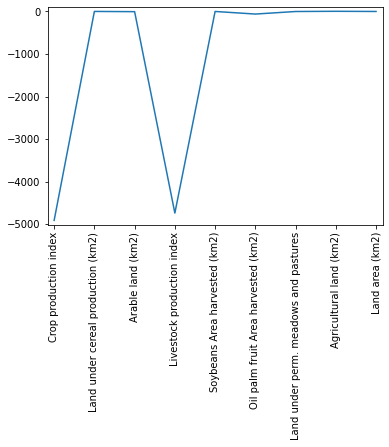

In [24]:
# Finding out which features are significant for the forest loss.
X = info.drop(columns=['Forest area (km2)'])
y = info.iloc[:, [9]]
df_columns = info.drop(columns=['Forest area (km2)']).columns
lasso = Lasso(alpha=0.1, normalize=True)

lasso.fit(X, y)

lasso_coef = lasso.coef_
print(lasso_coef)

plt.plot(range(len(df_columns)), lasso_coef)
plt.xticks(range(len(df_columns)), df_columns.values, rotation=90)
plt.margins(0.02)
plt.show()


[  -0.45839578  -15.05663307    0.11778832 -104.0867336    -4.2360611
   12.5545785     0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6596711087.488548, tolerance: 239501837.91483653
  positive)


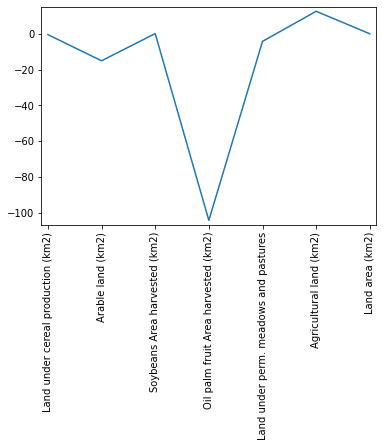

In [25]:
# Finding out which 1 more feature is significant
X = info.drop(columns=['Forest area (km2)', 'Crop production index', 'Livestock production index'])
y = info.iloc[:, [9]]
df_columns = info.drop(columns=['Forest area (km2)', 'Crop production index', 'Livestock production index']).columns
lasso = Lasso(alpha=0.1, normalize=True)

lasso.fit(X, y)

lasso_coef = lasso.coef_
print(lasso_coef)

plt.plot(range(len(df_columns)), lasso_coef)
plt.xticks(range(len(df_columns)), df_columns.values, rotation=90)
plt.margins(0.02)
plt.show()

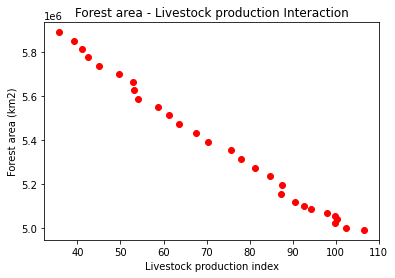

In [26]:
#Simple scatter plot for Livestock
plt.scatter(info['Livestock production index'], info['Forest area (km2)'], color='red')
plt.title('Forest area - Livestock production Interaction')
plt.xlabel('Livestock production index')
plt.ylabel('Forest area (km2)')
plt.show()


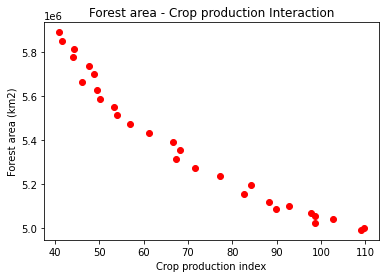

In [27]:
#Simple scatter plot for Crop production
plt.scatter(info['Crop production index'], info['Forest area (km2)'], color='red')
plt.title('Forest area - Crop production Interaction')
plt.xlabel('Crop production index')
plt.ylabel('Forest area (km2)')
plt.show()

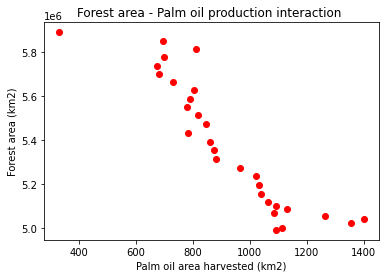

In [28]:
#Simple scatter plot
plt.scatter(info['Oil palm fruit Area harvested (km2)'], info['Forest area (km2)'], color='red')
plt.title('Forest area - Palm oil production interaction ')
plt.xlabel('Palm oil area harvested (km2)')
plt.ylabel('Forest area (km2)')
plt.show()

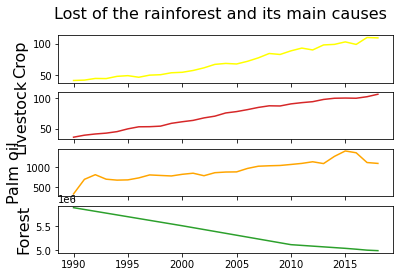

In [29]:
# Multiplre lines plot

#Create combo chart
fig, (ax1, ax2, ax3, ax4)  = plt.subplots(4, 1, sharex=True)
#bar plot creation
fig.suptitle('Lost of the rainforest and its main causes', fontsize=16)
#ax1.set_title('Lost of the rainforest and its main causes', fontsize=16)
color = 'yellow'
ax1.set_ylabel('Crop', fontsize=16)
ax1 = sns.lineplot(ax=ax1, x=info.index, y='Crop production index',  data = info, color=color)
#ax1.tick_params(axis='y', color=color)
#specify we want to share the same x-axis
color = 'tab:red'
#line plot creation
ax2.set_ylabel('Livestock', fontsize=16)
ax2 = sns.lineplot(ax=ax2, x=info.index, y='Livestock production index', data = info, color=color)
#ax2.tick_params(axis='y', color=color)
color = 'orange'
ax3.set_ylabel('Palm oil', fontsize=16)
ax3 = sns.lineplot(ax=ax3, x=info.index, y='Oil palm fruit Area harvested (km2)', data = info, color=color)
#ax2.tick_params(axis='y', color=color)

color = 'tab:green'
ax1.set_xlabel('Year', fontsize=16)
ax4.set_ylabel('Forest', fontsize=16)
ax4 = sns.lineplot(ax=ax4, x=info.index, y='Forest area (km2)', data = info, color=color)
#ax3.tick_params(axis='y', color=color)
#show plot
plt.show()

---
Trying out ML  stuff

In [31]:
drivers = info[['Forest area (km2)', 'Crop production index', 'Livestock production index']]
drivers.reset_index(inplace=True)
drivers = drivers.rename(columns = {'index':'Year'})
drivers.head()
forest = drivers[['Year', 'Forest area (km2)']]
crop = drivers[['Year', 'Crop production index']]
crop = drivers[['Year', 'Livestock production index']]

In [33]:
#define training/testing sets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

lab_enc = preprocessing.LabelEncoder()
Xe = drivers.drop(columns='Forest area (km2)')
ye = drivers[['Forest area (km2)']]
X = Xe.astype('int')
y = ye.astype('int')
X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.75, test_size=0.25, random_state=42)

In [34]:
X_train

,Year,Crop production index,Livestock production index
26,2016,98,99
13,2003,66,70
15,2005,67,77
11,2001,57,63
17,2007,77,84
1,1991,41,39
4,1994,47,44
5,1995,48,49
2,1992,44,41
24,2014,98,99


In [35]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_train)
print('Train accuracy score:',accuracy_score(y_train,y_pred))
print('Test accuracy score:', accuracy_score(y_test,logreg.predict(X_test)))

Train accuracy score: 0.9523809523809523
Test accuracy score: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [37]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier as RFC
rfc_b = RFC(n_estimators=1000, n_jobs=-1, random_state=0)
rfc_b.fit(X_train,y_train)
y_pred = rfc_b.predict(X_train)

print('Train accuracy score:',accuracy_score(y_train,y_pred))
print('Test accuracy score:', accuracy_score(y_test,rfc_b.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Train accuracy score: 1.0
Test accuracy score: 0.0


In [38]:
# Ridge Regression
from sklearn.linear_model import Ridge
import numpy as np
ridge = Ridge()
ridge.fit(X_train,y_train)
y_prob = ridge.predict(X_train)
y_pred = np.asarray([np.argmax(line) for line in y_prob])
yp_test = ridge.predict(X_test)
test_preds = np.asarray([np.argmax(line) for line in yp_test])
print(accuracy_score(y_train,y_pred))
print(accuracy_score(y_test,test_preds))

0.0
0.0
